In [26]:
import os
import sys
import math
import logging
import structlog
from pathlib import Path
import json
import re
from itertools import product, combinations
from enum import Enum

import tomli
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12, 6.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
logging.basicConfig(level=logging.WARNING, stream=sys.stdout)

In [4]:
import pytanis
from pytanis import GSheetsClient, PretalxClient, get_cfg
from pytanis.google import Scope, gsheet_rows_for_fmt, worksheet_range
from pytanis.review import read_assignment_as_df, save_assignments_as_json, Col
from pytanis.pretalx import subs_as_df, reviews_as_df, speakers_as_df
from pytanis.utils import implode
from pytanis.highs import set_solution_from_file, read_sol_file

In [5]:
# Be aware that this notebook might only run with the following version
pytanis.__version__ 

'0.7.1.post1.dev5+g54f57c2.d20240618'

In [6]:
# Import event-specific settings to don't have them here in the notebook
with open('config.toml', 'rb') as fh:
    cfg = tomli.load(fh)


In [39]:
class Rooms(str, Enum):
    SPECTRUM = "Spectrum"
    TITANIUM3 = "Titanium3"
    HELIUM3 = "Helium3"
    PLATINUM3 = "Platinum3"
    EUROPIUM2 = "Europium2"
    HASSIUM = "Hassium"
    PALLADIUM = "Palladium"
    FERRUM = "Ferrum"
    DYNAMICUM = "Dynamicum"

    def __str__(self):
        return str(self.value)

## Gather all Data, i.e. Submissions, Votes and Scheduling Data

In [41]:
pretalx_client = PretalxClient(blocking=True)
talks_count, talks = pretalx_client.submissions(cfg['event_name'], params={"questions": "all", "state": ["confirmed", "accepted"]})
talks = list(talks)
rooms_count, rooms = pretalx_client.rooms(cfg['event_name'])
rooms = list(rooms)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [62]:
talks_df = subs_as_df(talks, with_questions=True)
# Ignore Keynotes when scheduling
talks_df = talks_df.loc[~(talks_df[Col.submission_type] == "Keynote")]
# Ignore Kids workshop when scheduling
talks_df = talks_df.loc[~(talks_df[Col.submission_type] == "Kids Workshop")]
# Split track up in main/sub track
talks_df.insert(2, 'Main track', talks_df[Col.track].map(lambda x: x.split(":")[0] if not pd.isna(x) else x))
talks_df[Col.track] = talks_df[Col.track].map(lambda x: x.split(":")[-1] if not pd.isna(x) else x).map(lambda x: re.sub('[\W_]+', '', x))

In [64]:
main_tracks = [mt for mt in talks_df["Main track"].unique() if mt != 'Plenary']
sub_tracks = [st for st in talks_df[Col.track].unique() if st != 'Plenary']
print("Main tracks", main_tracks)
print("Sub tracks", sub_tracks)

Main tracks ['PyCon', 'Sponsor', 'PyData', 'General']
Sub tracks ['MLOpsDevOps', 'Security', 'Sponsor', 'DataHandlingEngineering', 'DjangoWeb', 'NaturalLanguageProcessingAudioinclGenerativeAINLP', 'MachineLearningDeepLearningStatistics', 'ProgrammingSoftwareEngineering', 'Others', 'EducationCareerLife', 'EmbeddedSystemsRobotics', 'ComputerVisioninclGenerativeAICV', 'PythonLanguageEcosystem', 'PyDataScientificLibrariesStack', 'GenerativeAI', 'VisualisationJupyter', 'Testing', 'Rust', 'InfrastructureHardwareCloud', 'EthicsPrivacy', 'ResearchSoftwareEngineering', 'CommunityDiversity']


In [65]:
talk2main_track = pd.concat([talks_df[Col.submission], pd.get_dummies(talks_df["Main track"], dtype=int)], axis=1)
talk2main_track.head()

,Submission,General,PyCon,PyData,Sponsor
0,3CYZUH,0,1,0,0
1,3DSU8V,0,1,0,0
4,3MRJLS,0,0,0,1
5,3SLWC8,0,0,0,1
6,3VYSMS,0,1,0,0


In [66]:
talk2main_track = talk2main_track.melt(id_vars=Col.submission, value_vars=talk2main_track.columns, var_name='Main track').sort_values([Col.submission, "Main track"]).set_index([Col.submission, "Main track"]).to_dict()['value']

In [67]:
talk2sub_track = pd.concat([talks_df[Col.submission], pd.get_dummies(talks_df["Track"], dtype=int)], axis=1)
talk2sub_track.head()

,Submission,CommunityDiversity,ComputerVisioninclGenerativeAICV,DataHandlingEngineering,DjangoWeb,EducationCareerLife,EmbeddedSystemsRobotics,EthicsPrivacy,GenerativeAI,InfrastructureHardwareCloud,MLOpsDevOps,MachineLearningDeepLearningStatistics,NaturalLanguageProcessingAudioinclGenerativeAINLP,Others,ProgrammingSoftwareEngineering,PyDataScientificLibrariesStack,PythonLanguageEcosystem,ResearchSoftwareEngineering,Rust,Security,Sponsor,Testing,VisualisationJupyter
0,3CYZUH,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3DSU8V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3MRJLS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,3SLWC8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,3VYSMS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
talk2sub_track = talk2sub_track.melt(id_vars=Col.submission, value_vars=talk2sub_track.columns, var_name='Track').sort_values([Col.submission, "Track"]).set_index([Col.submission, "Track"]).to_dict()['value']

In [69]:
talk2idx = {v: k for k, v in enumerate(set(talks_df[Col.submission].to_list()))}
idx2talk = {v: k for k, v in talk2idx.items()}

In [70]:
votes_df = pd.read_csv(
    f"https://pretalx.com/{cfg['event_name']}/schedule/export/public_votes.csv",
    storage_options = {
        'Authorization': f'Token {get_cfg().Pretalx.api_token}',
        'Content-Type': 'text/plain'
    }
)

votes_df = votes_df.rename(columns={'code': Col.submission, 'score': Col.vote_score})
# Remove votes for submissions that wheren't accepted
votes_df = votes_df.loc[votes_df[Col.submission].apply(lambda talk: talk in talk2idx.keys())].reset_index(drop=True)
# Remove votes equal 1 as this meant "being indifferent"
votes_df = votes_df.loc[votes_df[Col.vote_score] > 1]
# Move a score of 2 to 1, so that "must see" counts tripple compared to "want to see"
votes_df.loc[votes_df[Col.vote_score] == 2, Col.vote_score] = 1

In [71]:
talk_lengths = {s:d for _, (s, d) in talks_df[[Col.submission, Col.duration]].iterrows()}
print(talk_lengths)
# NO CONSECUTIVE TUTORIALS THIS YEAR
# following tutorials build sequences and thus need to be in the same session and after one another
# consecutive_tutorials = [("VFZ3VT", "DEQM3J"), ("KUKU9Z", "YWTRSG")]
sponsored_talks = [t.code for t in talks if "Sponsor" in t.submission_type.en]

{'3CYZUH': 30, '3DSU8V': 45, '3MRJLS': 45, '3SLWC8': 30, '3VYSMS': 30, '3WLDMQ': 30, '7CL3KS': 45, '7CXSPN': 45, '7FV8B3': 90, '7KWDA3': 30, '7PDARV': 30, '83QH37': 30, '89BX8V': 30, '8PFFPS': 30, '8S3RC3': 30, '933YXH': 30, '98FQDY': 30, '9CRNU3': 30, '9NFHAS': 45, '9RBNMV': 30, '9Y9DM8': 90, 'ABWHSD': 30, 'ADSXCA': 30, 'AEUZGX': 30, 'AGY8CT': 30, 'AJDYRL': 30, 'AWPYGE': 30, 'AYN837': 30, 'B7GU98': 30, 'B8TUR9': 30, 'BJKSGK': 45, 'BLKYGU': 30, 'BPRXKZ': 45, 'BR3D83': 45, 'C3RVM3': 90, 'CHAEXA': 30, 'CMTKZS': 30, 'CP3TKB': 90, 'CPCNRZ': 30, 'CRNJWQ': 30, 'CTUEJX': 30, 'CUJMCD': 30, 'CVMPVG': 30, 'CYSXFM': 30, 'CZXBEP': 30, 'D8N3JR': 30, 'DEHZHK': 45, 'DHZPR7': 90, 'DNVCEY': 30, 'DPAPUA': 30, 'DQTMJB': 45, 'DSHASE': 30, 'DVABUG': 30, 'ECNDQM': 30, 'EDJ8N7': 30, 'EN3QPQ': 30, 'EPAVRR': 30, 'ER3V7W': 30, 'F7RDPT': 30, 'F9EFXA': 30, 'FGEUJJ': 30, 'FGFFEE': 30, 'FGV9BJ': 30, 'FSK3PE': 30, 'FUX3FR': 30, 'G3AT7E': 30, 'GJ9MVT': 45, 'GRWYQB': 45, 'GUEAHT': 30, 'GUKTNX': 30, 'GURXPK': 30, 'HGJ3

In [72]:
pops_dict = votes_df.groupby(Col.submission)['Vote Score'].sum().to_dict()
# give sponsored talks the median popularity
for talk in set(talks_df[Col.submission].to_list()) - set(pops_dict.keys()):
    pops_dict[talk] = np.median(list(pops_dict.values()))
# normalize the popularities
min_pop = np.min(list(pops_dict.values()))
max_pop = np.max(list(pops_dict.values()))
pops_dict = {k:(v - min_pop) / (max_pop - min_pop) for k, v in pops_dict.items()}
print({k: f"{v:.3}" for k, v in pops_dict.items()})

{'3CYZUH': '0.243', '3DSU8V': '0.343', '3VYSMS': '0.3', '3WLDMQ': '0.157', '7CL3KS': '0.314', '7CXSPN': '0.471', '7FV8B3': '0.2', '7PDARV': '0.2', '83QH37': '0.657', '89BX8V': '0.143', '8PFFPS': '0.971', '8S3RC3': '0.0857', '933YXH': '0.186', '98FQDY': '0.129', '9CRNU3': '0.343', '9NFHAS': '0.0429', '9RBNMV': '0.0857', '9Y9DM8': '0.171', 'ABWHSD': '0.0857', 'ADSXCA': '0.643', 'AEUZGX': '0.186', 'AGY8CT': '0.457', 'AJDYRL': '0.671', 'AWPYGE': '0.429', 'AYN837': '0.0429', 'B7GU98': '0.329', 'B8TUR9': '0.157', 'BJKSGK': '0.0857', 'BLKYGU': '0.271', 'BR3D83': '0.143', 'C3RVM3': '0.414', 'CHAEXA': '0.686', 'CMTKZS': '0.1', 'CP3TKB': '0.329', 'CPCNRZ': '0.729', 'CRNJWQ': '0.329', 'CTUEJX': '0.129', 'CUJMCD': '0.429', 'CVMPVG': '0.186', 'CZXBEP': '0.143', 'DEHZHK': '0.371', 'DNVCEY': '0.357', 'DPAPUA': '0.271', 'DQTMJB': '0.214', 'DSHASE': '0.414', 'ECNDQM': '0.457', 'EDJ8N7': '0.529', 'EN3QPQ': '0.214', 'EPAVRR': '0.271', 'ER3V7W': '0.271', 'F7RDPT': '0.0714', 'F9EFXA': '0.2', 'FGEUJJ': '0.2

In [73]:
room_caps_dict = {room.name.en.replace('-', ''):room.capacity for room in rooms}
print(room_caps_dict)
# normalize room_caps like popularity by dividing by min
min_room_cap = np.min(list(room_caps_dict.values()))
max_room_cap = np.max(list(room_caps_dict.values()))
room_caps_dict = {k: (v - min_room_cap) / (max_room_cap - min_room_cap) for k, v in room_caps_dict.items()}
tutorial_rooms =  {Rooms.FERRUM, Rooms.DYNAMICUM}
talk_rooms = set(room_caps_dict.keys()) - tutorial_rooms
print(room_caps_dict)

{'Spectrum': 1072, 'Titanium3': 300, 'Helium3': 284, 'Platinum3': 263, 'Europium2': 161, 'Hassium': 96, 'Palladium': 63, 'Ferrum': 269, 'Dynamicum': 150}
{'Spectrum': np.float64(1.0), 'Titanium3': np.float64(0.2348860257680872), 'Helium3': np.float64(0.21902874132804756), 'Platinum3': np.float64(0.19821605550049554), 'Europium2': np.float64(0.09712586719524281), 'Hassium': np.float64(0.03270564915758176), 'Palladium': np.float64(0.0), 'Ferrum': np.float64(0.20416253716551042), 'Dynamicum': np.float64(0.08622398414271557)}


In [74]:
# generate penalty for a talk given its popularity in a certain room
talk_room_penalty = {(talk, room): (pop - cap)**2 for (talk, pop), (room, cap) in product(pops_dict.items(), room_caps_dict.items())} 
min(talk_room_penalty.values()), max(talk_room_penalty.values())

(np.float64(0.0), np.float64(1.0))

In [75]:
# generate cooccurrence penalty for all talks scheduled at the same time-slot & room using Gram-matrix
n_users = votes_df['voter'].nunique()
n_talks = len(talks_df)

def user_interaction(user_votes):
    x = np.zeros(n_talks)
    for _, (sub, vote_score) in user_votes[[Col.submission, Col.vote_score]].iterrows():
        x[talk2idx[sub]] = vote_score
    return x

X = np.vstack(votes_df.groupby("voter").apply(user_interaction))
assert X.shape == (n_users, n_talks)

cooccurance_penalty = X.T @ X

# set diagonal to 0 since a talk is always parallel to itself.
np.fill_diagonal(cooccurance_penalty, 0.)

# normalize with max as sponsored talks will get the value 1.
cooccurance_penalty /= cooccurance_penalty.max() 

/var/folders/ts/4k10rtg93lb9rpbs7m08v8480000gn/T/ipykernel_20348/2592006779.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = np.vstack(votes_df.groupby("voter").apply(user_interaction))


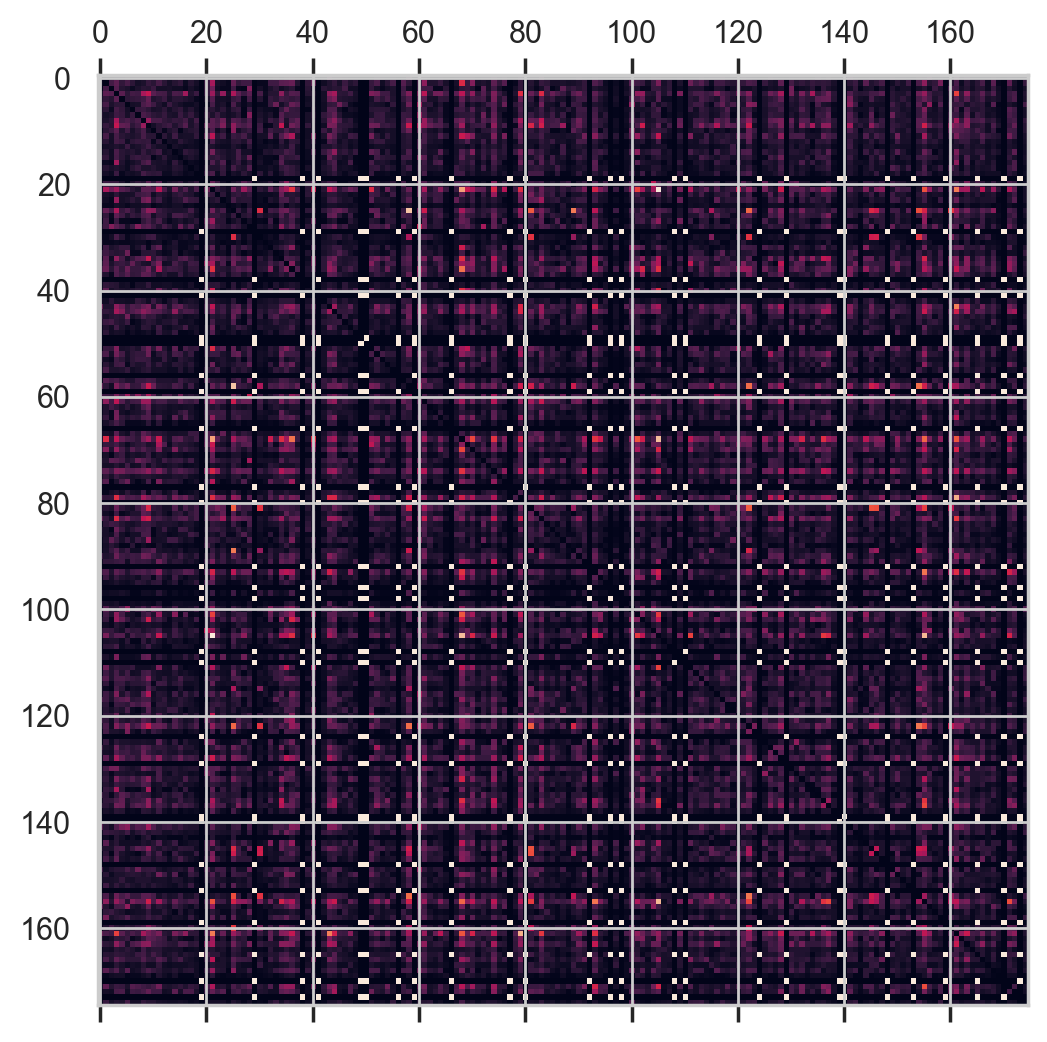

In [76]:
# for sponsored talks set a high cooccurence penalty
for t1, t2 in combinations(sponsored_talks, 2):
   cooccurance_penalty[talk2idx[t1], talk2idx[t2]] = cooccurance_penalty[talk2idx[t2], talk2idx[t1]] = 1.
    
# set diagonal to 0 since a talk is always parallel to itself.
np.fill_diagonal(cooccurance_penalty, 0.)

talk_cooccurence_penalty = {(t1, t2): cooccurance_penalty[talk2idx[t1], talk2idx[t2]]**2 for t1, t2 in product(talk2idx.keys(), talk2idx.keys())}
plt.matshow(cooccurance_penalty);

## Time-Table Scheduling

We consider following constraints:
* each talk must be assigned once
* each room/timeslot combination can only be occupied by one talk at most
* the length of the timeslot must match the length of the talk
* some tutorials have part 1 & 2,thus need to be consecutive

We optimize an objective which considers:
1. the preferences for day and time of the speakers are considered (if they provided some)
2. the more popular a talk is, the more capacity the assigned room should have
3. if many people are interested in seeing two talks (data from the votes) these talks should rather not be scheduled in parallel (sponsored talks should never be in parallel)
4. if possible have in the same session (block of talks) the same main track, e.g. PyData, 
5. or even the same sub track, e.g.PyData: Data Handling, assuming that people have certain preferences regarding tracks.

The importance is 1 > 2 > 3 > 4 > 5

In [77]:
import pyomo.environ as pyo
import pyomo.gdp as pyogdp
from pyomo.contrib.appsi.solvers import Highs
from tqdm.auto import tqdm

In [78]:
model = pyo.ConcreteModel(name="PyConDE/PyData Schedule 2025")

##############
# Index Sets #
##############

model.sTalks = pyo.Set(initialize=talks_df[Col.submission].values, ordered=True)
model.sDays = pyo.Set(initialize=["Wednesday", "Thursday", "Friday"], ordered=True)
model.sSessions = pyo.Set(initialize=["Morning", "Afternoon1", "Afternoon2"], ordered=True)
model.sSlots = pyo.Set(initialize=["First", "Second", "Third"], ordered=True)
model.sRooms = pyo.Set(initialize=room_caps_dict.keys(), ordered=True)
model.sMainTracks = pyo.Set(initialize=main_tracks, ordered=True)
model.sSubTracks = pyo.Set(initialize=sub_tracks, ordered=True)

##############
# Parameters #
##############

## Set here the preferences of the speakers/talks for the slots
def init_slot_preference(model, t, d, s, l, r):
    if t in {"S8MUBF"} and d == "Wednesday" and s == "Morning":
        return 1
    elif t in {"KCV9RS"} and d == "Thursday" and s == "Morning": 
        return 1
    elif t in {"ZACM3E"} and not (d == "Friday" and s in {"Afternoon1", "Afternoon2"}):
        return 1
    else:
        return 0

model.pPreferences = pyo.Param(model.sTalks, model.sDays, model.sSessions, model.sSlots, model.sRooms, initialize=init_slot_preference, mutable=False)
model.pTalkRoomPenalty = pyo.Param(model.sTalks, model.sRooms, initialize=talk_room_penalty, mutable=False)
model.pCoOccurencesPenalty = pyo.Param(model.sTalks, model.sTalks, initialize=talk_cooccurence_penalty, mutable=False)
model.pTalk2MainTrack = pyo.Param(model.sTalks, model.sMainTracks, initialize=talk2main_track, mutable=False)
model.pTalk2SubTrack = pyo.Param(model.sTalks, model.sSubTracks, initialize=talk2sub_track, mutable=False)

def init_slot_length(model, d, s, l, r):
    if d == "Wednesday":
        if s == "Morning":
            if r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 30 if r in {Rooms.HASSIUM, Rooms.PALLADIUM} else 45
                else:
                    return 0  # no third slot
            else:
                return 90 if l == "First" else 0
        elif s == "Afternoon1":
            if r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 30 if r in {Rooms.HASSIUM, Rooms.PALLADIUM} else 45
                else:  # Third
                    return 30
            else:
                if l == "First":
                    return 90
                elif l == "Second":
                    return 0
                else:  # Third
                    return 30
        else: # "Afternoon 2":
            if l == "First":
                return 30
            elif l == "Second":
                return 30
            else:
                return 0 # no Third slot
    elif d == "Thursday":
        if s == "Morning":
            if r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 30
                else:
                    return 30 if r in {Rooms.EUROPIUM2, Rooms.HASSIUM, Rooms.PALLADIUM} else 45
            else:
                return 90 if l == "First" else 0
        elif s == "Afternoon1":
            if r == Rooms.SPECTRUM:
                return 0  # panel in the Spectrum
            elif r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 45
                else:
                    return 0 # no Third slot
            else:
                return 90 if l == "First" else 0
        else: # Afternoon 2
            if r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 45
                else:
                    return 0 # no Third slot
            else:
                return 90 if l == "First" else 0
    else: # Friday
        if s == "Morning":
            if r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 30
                else:
                    return 30 if r in {Rooms.HASSIUM, Rooms.PALLADIUM} else 45
            else:
                return 90 if l == "First" else 0
        elif s == "Afternoon1":
            if r in talk_rooms:
                if l in {"First", "Second"}:
                    return 30
                else:
                    return 0  # no Third slot
            else:
                return 90 if l == "First" else 0
        else: # Afternoon 2
            if l in {"First", "Second"}:
                return 30
            else: # Third slot
                return 30 if r in {Rooms.TITANIUM3, Rooms.HELIUM3, Rooms.PLATINUM3, Rooms.EUROPIUM2, Rooms.HASSIUM, Rooms.PALLADIUM} else 0
    raise RuntimeError(f"Unhandled case {d}, {s}, {l}, {r}")

model.pSlotLengths = pyo.Param(model.sDays, model.sSessions, model.sSlots, model.sRooms, initialize=init_slot_length, mutable=False)
model.pTalkLengths = pyo.Param(model.sTalks, initialize=talk_lengths, mutable=False)

#############
# Variables #
#############

## Auxiliary variables
# indicator if talk t is in room r
model.vbTalkRoom = pyo.Var(model.sTalks, model.sRooms, domain=pyo.Binary) 
# indicator if talk t is in day/session/slot combination. Used later to calculate cooccurences.
model.vbParallelTalk = pyo.Var(model.sTalks, model.sDays, model.sSessions, model.sSlots, domain=pyo.Binary) 
# indicator if two talks are in the same day/session/slot combination, thus are running in parallel and only one can be attended to.
model.vbCoOccurences = pyo.Var(model.sTalks, model.sTalks, model.sDays, model.sSessions, model.sSlots, domain=pyo.Binary) 
# indicator if two talks are in the same day
model.vbSameDay = pyo.Var(model.sTalks, model.sTalks, model.sDays, domain=pyo.Binary)
# indicator if main track occures in day/session/room combination, i.e. occurs in the current session of a room
model.vbMainTrackSessionRoom = pyo.Var(model.sDays, model.sSessions, model.sRooms, model.sMainTracks, domain=pyo.Binary) 
# indicator if sub track occures in day/session/room combination, i.e. occurs in the current session of a room
model.vbSubTrackSessionRoom = pyo.Var(model.sDays, model.sSessions, model.sRooms, model.sSubTracks, domain=pyo.Binary)
# indicator if talk t is in day/session/room combination, i.e. talk is in a session of a room.
model.vbTalkSession = pyo.Var(model.sTalks, model.sDays, model.sSessions, model.sRooms, domain=pyo.Binary)

## Decision variable
model.vbSchedule = pyo.Var(model.sTalks, model.sDays, model.sSessions, model.sSlots, model.sRooms, domain=pyo.Binary)

###############
# Constraints #
###############

# Make sure talk lengths fits slot lengths
model.ctTalkSlotFit = pyo.ConstraintList()
for t in model.sTalks:
    model.ctTalkSlotFit.add(sum(model.vbSchedule[t, d, s, l, r] * model.pSlotLengths[d, s, l, r] for d, s, l, r in product(model.sDays, model.sSessions, model.sSlots, model.sRooms)) == model.pTalkLengths[t])
    
# Make sure each room/timeslot-combination is occupied only with one talk at most
model.ctTimeRoomOccup = pyo.ConstraintList()
for d, s, l, r in product(model.sDays, model.sSessions, model.sSlots,  model.sRooms):
    model.ctTimeRoomOccup.add(sum(model.vbSchedule[:, d, s, l, r]) <= 1)
    
# Set vbParallelTalk auxiliary variable
model.ctParallelTalk = pyo.ConstraintList()
for t, d, s, l in product(model.sTalks, model.sDays, model.sSessions, model.sSlots):
    model.ctParallelTalk.add(model.vbParallelTalk[t, d, s, l] == sum(model.vbSchedule[t, d, s, l, :]))
                               
# Make sure each talk is assigned once
model.ctTalkAssigned = pyo.ConstraintList()
for t in model.sTalks:
    model.ctTalkAssigned.add(sum(model.vbSchedule[t, :, :, :, :]) == 1)

# Set vbCoOccurences auxiliary variable
model.ctCoOccurences = pyo.ConstraintList()
for d, s, l in product(model.sDays, model.sSessions, model.sSlots):
    for t1, t2 in combinations(model.sTalks, 2):
        model.ctCoOccurences.add(model.vbCoOccurences[t1, t2, d, s, l] + 1 >= model.vbParallelTalk[t1, d, s, l] + model.vbParallelTalk[t2, d, s, l])

# Set vbSameDay auxiliary variable
model.ctSameDay = pyo.ConstraintList()
for d in model.sDays:
    for t1, t2 in combinations(model.sTalks, 2):
        model.ctSameDay.add(2*model.vbSameDay[t1, t2, d] <= sum(model.vbParallelTalk[t1, d, s, l] + model.vbParallelTalk[t2, d, s, l] for s, l in product(model.sSessions, model.sSlots)))

# Set vbTalkRoom auxiliary variable
model.ctTalkRoom = pyo.ConstraintList()
for t, r in product(model.sTalks, model.sRooms):
    model.ctTalkRoom.add(sum(model.vbSchedule[t, ..., r]) == model.vbTalkRoom[t, r])

# Enforce that some talks need to be in consecutive order
# NOT NEEDED THIS YEAR!
# def ct_consecutive_slots(model, t1, t2):
#     possibilities = [(("Tuesday", "Afternoon1", "First", r), ("Tuesday", "Afternoon2", "First", r)) for r in tutorial_rooms]
#     possibilities.extend([(("Wednesday", "Morning1", "First", r), ("Wednesday", "Morning2", "First", r)) for r in tutorial_rooms])
#     return [[model.vbSchedule[t1, d1, s1, l1, r1] + model.vbSchedule[t2, d2, s2, l2, r2] == 2] for (d1, s1, l1, r1), (d2, s2, l2, r2) in possibilities]

# Set disjunction constraint for consecutive tutorials
# for i, (t1, t2) in enumerate(consecutive_tutorials):
#     # there seems to be no List object for disjunctions, thus we use setattr
#     setattr(model, f'disjTutorial{i}', pyogdp.Disjunction(expr=ct_consecutive_slots(model, t1, t2)))
    
# Set vbTalkSession auxiliary variable
model.ctTalkSession = pyo.ConstraintList()
for t, d, s, r in product(model.sTalks, model.sDays, model.sSessions, model.sRooms):
    model.ctTalkSession.add(model.vbTalkSession[t, d, s, r] == sum(model.vbSchedule[t, d, s, :, r]))
    
# Set vbMainTrackSessionRoom auxiliary variable
model.ctMainTrackSessionRoom = pyo.ConstraintList()
for d, s, r, mt in product(model.sDays, model.sSessions, model.sRooms, model.sMainTracks):
    model.ctMainTrackSessionRoom.add(model.vbMainTrackSessionRoom[d, s, r, mt]*len(model.sSlots) >= sum(model.vbTalkSession[t, d, s, r]*model.pTalk2MainTrack[t, mt] for t in model.sTalks))
    
# Set vbSubTrackSessionRoom auxiliary variable
model.ctSubTrackSessionRoom = pyo.ConstraintList()
for d, s, r, st in product(model.sDays, model.sSessions, model.sRooms, model.sSubTracks):
    model.ctSubTrackSessionRoom.add(model.vbSubTrackSessionRoom[d, s, r, st]*len(model.sSlots) >= sum(model.vbTalkSession[t, d, s, r]*model.pTalk2SubTrack[t, st] for t in model.sTalks))
    
#############
# Objective #
############# 

def objective(model):
    preference_term = pyo.dot_product(model.pPreferences, model.vbSchedule)
    pop_roomcap_term = pyo.dot_product(model.pTalkRoomPenalty, model.vbTalkRoom)
    cooccurance_terms = []
    for d, s, l in product(model.sDays, model.sSessions, model.sSlots):
        cooccurance_terms.append(sum(model.vbCoOccurences[t1, t2, d, s, l] * model.pCoOccurencesPenalty[t1, t2] for t1, t2 in combinations(model.sTalks, 2)))
        
    cooccurance_term = sum(cooccurance_terms) + sum(model.vbCoOccurences[...]) # last term forces vbCoOccurences to be 0 if possible
    main_tack_term = sum(model.vbMainTrackSessionRoom[...])  # the higher this number the more different tracks we have in a session. We want the opposite.
    sub_track_term = sum(model.vbSubTrackSessionRoom[...])  # see above
    
    return 100_000_000*preference_term - 1_000_000*pop_roomcap_term - 10_000*cooccurance_term - 100*main_tack_term - sub_track_term   

model.obj = pyo.Objective(sense=pyo.maximize, rule=objective)
pyo.TransformationFactory("gdp.bigm").apply_to(model)


In [79]:
# consistency check: amount of lengths of talks/timeslots must match, sponsored talks are considered normal talks
print("Slots:\n", pd.Series(model.pSlotLengths.values()).value_counts(), sep='')
print("\nTalks:\n", talks_df[Col.duration].value_counts(), sep='')

Slots:
30    129
0      68
45     32
90     14
Name: count, dtype: int64

Talks:
Duration
30    129
45     32
90     14
Name: count, dtype: int64


In [80]:
# Optionally write out the model file to solve it on the CLI directly, which provides more info while running
model.write(filename = "pyconde_pydata_schedule_20250222.mps", io_options = {"symbolic_solver_labels": True})

('pyconde_pydata_schedule_20250222.mps', 14262548560)

In [ ]:
# solve it here directly
# solver = Highs()
# solver.config.time_limit = 600. # 10 minutes, set to a number high enough to reach a feasible solution
# solver.config.load_solution = False
# sol = solver.solve(model)
# solver.load_vars() # only works if solution is valid/feasible

In [ ]:
# or better in the CLI 
#!highs pyconde_pydata_schedule_20240214.mps --solution_file 20240214.sol --time_limit 36000 # 10 hours!

## BE AWARE that this most likely runs more than 20 minutes to find a first feasible solutions and needs more than 12 hours to have a really nice solution.

In [ ]:
set_solution_from_file(model, "20240214.sol")

## Upload to GSheet

In [ ]:
schedule_df = pd.DataFrame([idx for idx, val in model.vbSchedule.items() if val() >= 0.5], columns=[Col.submission, "Day", "Session", "Slot", "Room"])
schedule_df = schedule_df.loc[:, ["Day", "Session", "Slot", "Room", Col.submission]]
schedule_df["Day"] = pd.Categorical(schedule_df["Day"], model.sDays.data())
schedule_df["Session"] = pd.Categorical(schedule_df["Session"], model.sSessions.data())
schedule_df["Slot"] = pd.Categorical(schedule_df["Slot"], model.sSlots.data())
schedule_df["Room"] = pd.Categorical(schedule_df["Room"], model.sRooms.data())
schedule_df.sort_values(list(schedule_df.columns[:-1]), inplace=True)
schedule_df.reset_index(drop=True, inplace=True)
timetable_df = schedule_df.pivot(index=["Day", "Session", "Slot"], columns="Room", values=Col.submission)

In [ ]:
timetable_df

In [ ]:
def cell_content(sub):
    talks_df_idx = talks_df.set_index(Col.submission)
    main_track = talks_df_idx.loc[sub, "Main track"]
    sub_track = talks_df_idx.loc[sub, "Track"]
    sub_track_max = 20
    sub_track = sub_track if len(sub_track) < sub_track_max else sub_track[:sub_track_max-3] + "..."
    sponsored = "\nSponsored" if sub in sponsored_talks else ""
    content = f"{sub2title[sub]}\n{main_track}: {sub_track}\n{talk_lengths[sub]}min\nPop: {pops_dict[sub]:.0%}{sponsored}"
    return f'=HYPERLINK("https://pretalx.com/orga/event/{cfg["event_name"]}/submissions/{sub}", "{content}")'

# make submission code a hyperlink
sub2title = {t.code: t.title.replace('"', "'") for t in talks}
schedule_df[Col.submission] = schedule_df[Col.submission].map(cell_content)
schedule_df["Room"] = schedule_df["Room"].map(lambda room: f"{room} Cap: {room_caps_dict[room]:.0%}")
timetable_df = schedule_df.pivot(index=["Day", "Session", "Slot"], columns="Room", values=Col.submission)

In [ ]:
gsheet_client = GSheetsClient(read_only=False)

In [ ]:
gsheet_client.save_df_as_gsheet(timetable_df.reset_index(), cfg['schedule_spread_id'], cfg['schedule_work_name'])

In [ ]:
from gspread_formatting import set_column_width, set_row_height, cellFormat, format_cell_range

worksheet = gsheet_client.gsheet(cfg['schedule_spread_id'], cfg['schedule_work_name'])
set_column_width(worksheet, 'D:J', 200)
set_row_height(worksheet, f"2:{len(timetable_df)+1}", 130)

fmt = cellFormat(wrapStrategy='WRAP')
format_cell_range(worksheet, worksheet_range(worksheet), fmt);

## References
* https://fran-espiga.medium.com/mixed-integer-programming-for-time-table-scheduling-eee326deda75
* https://towardsdatascience.com/schedule-optimisation-using-linear-programming-in-python-9b3e1bc241e1
* https://math.stackexchange.com/questions/432003/converting-absolute-value-program-into-linear-program